<a href="https://colab.research.google.com/github/JuanJGalindo/ML-Theory/blob/main/PINNs/1Introduccion_OsciladorHarmonico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PINN para el Oscilador Armónico 1D**

Este cuadernillo es una réplica traducida del Trabajo de Ben Moseley: ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/).

El código original se encuentra en: https://github.com/benmoseley/harmonic-oscillator-pinn

##**Revisión del Problema**

El problema de ejemplo que se resolverá, es el oscilador armónico amortiguado unidimensional:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
Con condiciones iniciales:
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
Nos centraremos en resolver el problem del estado subamortiguado, es decir, cuando:
$$
\delta < \omega_0~,~~~~~\mathrm{con}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

El problema está inspirado en el siguiente blog: https://beltoforion.de/en/harmonic_oscillator/.

##**Metodología**

>Primero, estimaremos la solución analítica como modelo comparativo de la calidad de predicción de una red neuronal estándard  y más adelante, para la predicción de una PINN.

>Luego, entrenaremos una red neuronal estándar para interpolar una solución parcial, usando algunos puntos de entrenamiento observados de la solución analítica, contaminados por ruido gaussiano, simulando la obtención y el ajuste a partir de datos experimentales.

>Por último, entrenaremos una PINN para extrapolar la solución completa fuera de los puntos de entrenamiento, usando la ecuación diferencial subyacente sobre unos puntos de colocación, que funciona como un término de regularización en la función de pérdida (Sesgo Inductivo).



In [53]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [54]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

class FCN(nn.Module):
    "Defines a connected network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

##**Generación de Datos de Entrenamiento**

> Primero, generamos unos datos de entrenamiento provenientes de la solución analítica, estos datos serán contaminados con ruido gaussiano blanco.

Para este problema, usaremos $\delta=2$, $\omega_0=20$, y entrenaremos una red en el dominio $x\in [0,1]$.

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([25, 1]) torch.Size([25, 1])


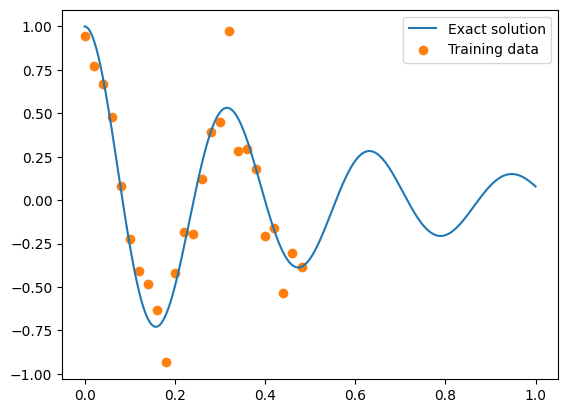

In [55]:
d, w0, snrdB = 2, 20, 10

# Signal to Noise Ratio

def varSNR(x,snrdB):
    Px = torch.mean(x**2)
    return Px/(10**(snrdB/10))

# Get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# Slice out a small number of points from the LHS of the domain
x_data = x[0:250:10]
y_data = y[0:250:10]
y_data = y_data + torch.sqrt(varSNR(y_data, snrdB))*torch.randn(y_data.shape)
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

##**Red Neuronal Convencional**

> A continuación, entrenaremos una red neuronal densa convencional para ajustar los datos de entrenamiento.

> La red neuronal ajusta bien la solución en la vecindad de los puntos de entrenamiento, pero carece de capacidad para la generalizar la misma, más allá de estos. Inclusive, se podría decir que sin tener una regularización, la red neuronal tiende a sobreajustar los datos de entrenamiento.

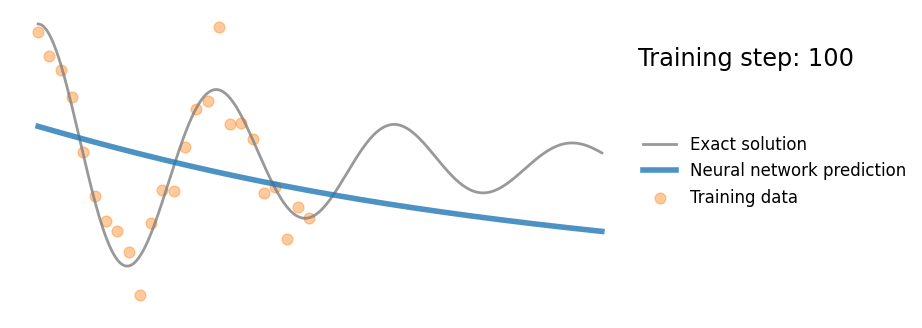

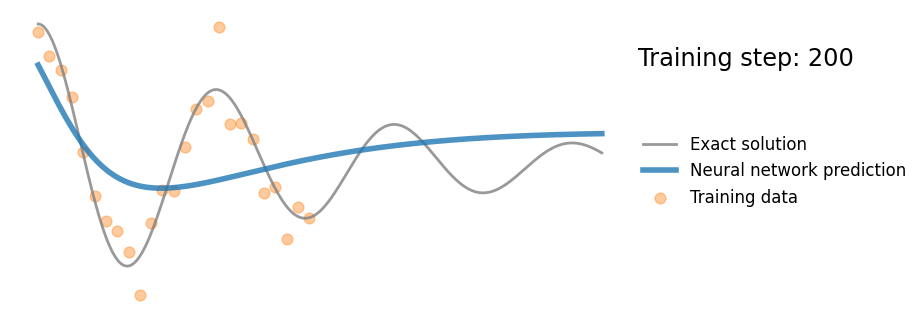

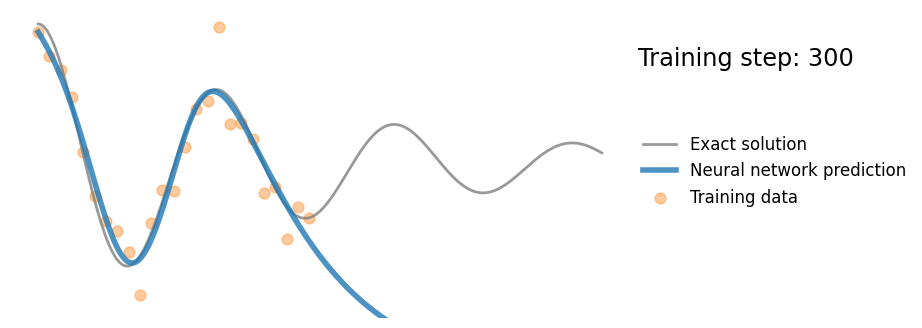

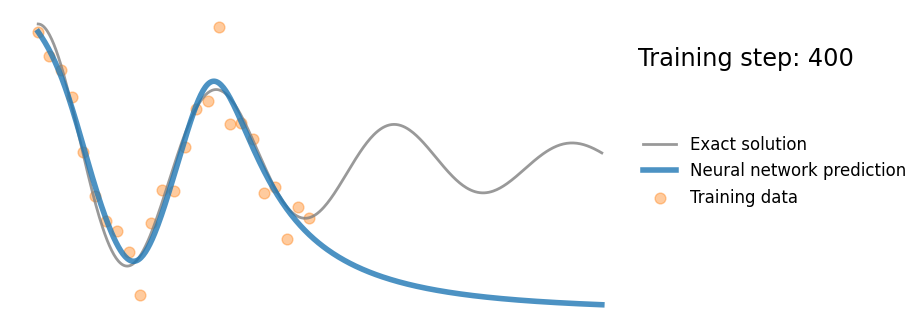

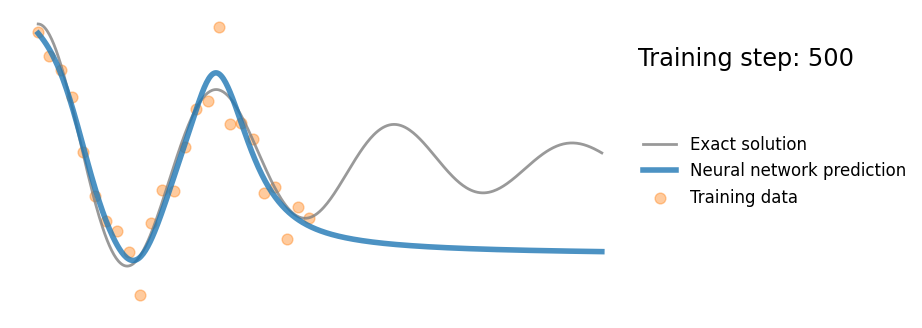

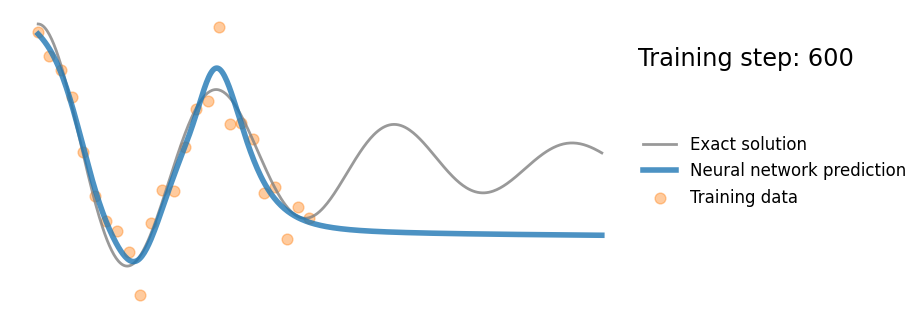

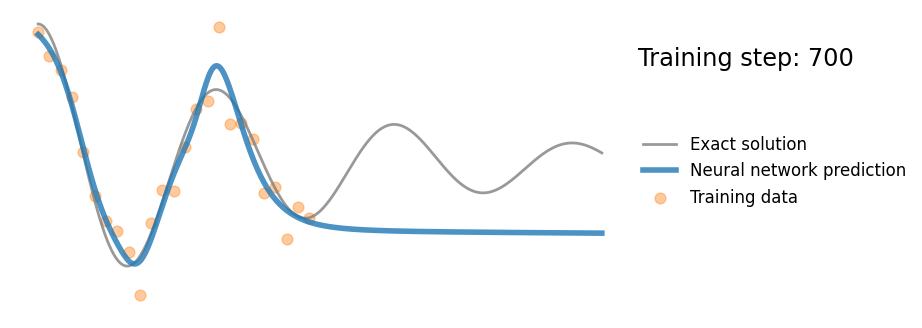

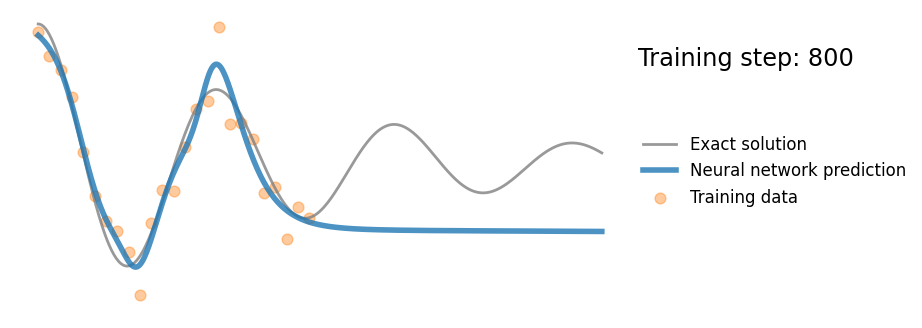

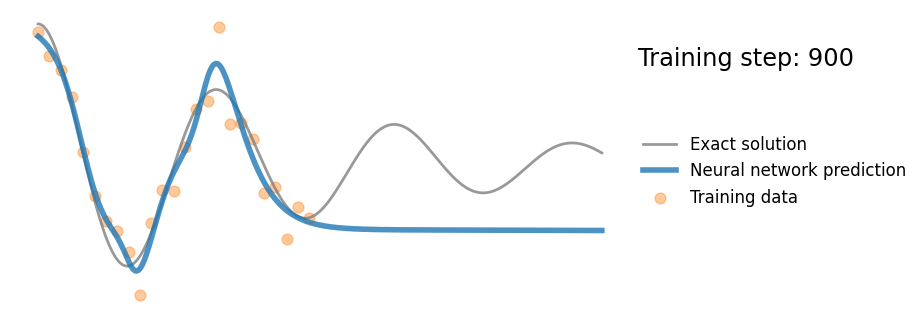

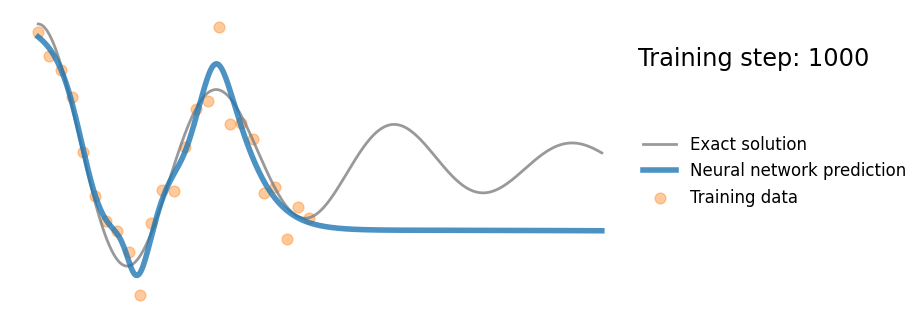

In [56]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

def lossPlot(loss_history, title):
  plt.figure()
  plt.plot(loss_history)
  plt.xlabel("Training step")
  plt.ylabel("Loss")
  plt.title(f"Loss Progression during {title} Training")
  plt.show()

def errorPlot(x, y, yh, title):
  # Calculate the absolute error
  error = torch.abs(yh - y)

  plt.figure(figsize=(8, 4))
  plt.scatter(x_cpu, yh_cpu, c=error, cmap='viridis', s=10)
  plt.colorbar(label="Absolute Error")
  plt.plot(x_cpu, y_cpu, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.title(f"{title} Prediction with Error Colormap")
  plt.legend()
  plt.show()

# Train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []

for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2) # Use mean squared error
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()


    # Plot the result as training progresses
    if (i+1) % 10 == 0:

        yh = model(x).detach()

        plot_result(x,y,x_data,y_data,yh)

        file = "/content/plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 100 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("nn.gif", files, fps=20, loop=0)

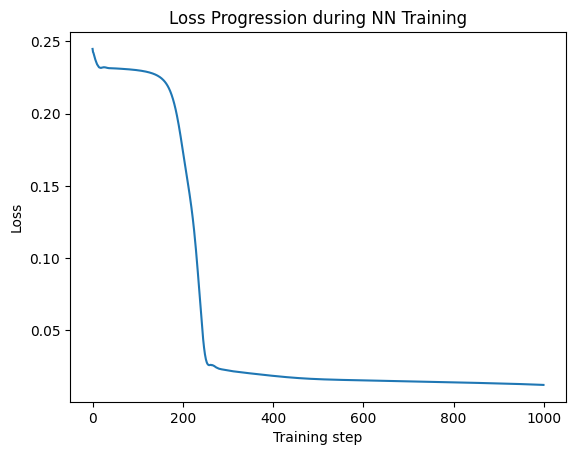

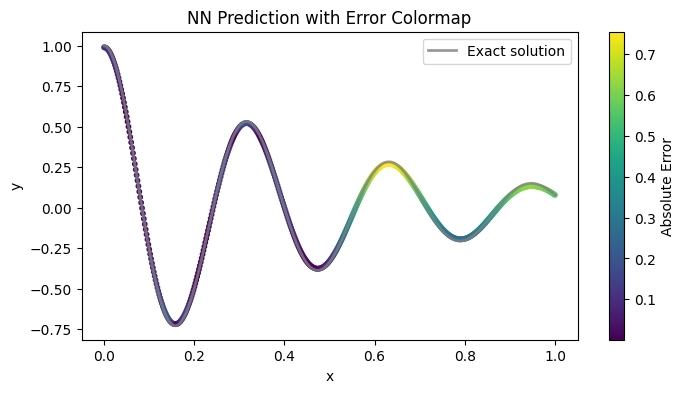

In [57]:
lossPlot(loss_history, "NN")
errorPlot(x, y, yh, "NN")

##**PINN / Data**

> Finalmente, se adiciona la ecuación diferencial subyacente ("physics loss") a la función de pérdida.

La pérdida física busca asegurar que la solución estimada es consistente con la ecuación diferencial subyacente que describe el sistema. Esto se da, al penalizar el residuo de la ecuación diferencial sobre el conjunto de puntos de colocación extraídos del dominio.

Aquí, evaluamos la pérdida física en 50 puntos uniformemente espaciados a lo largo del dominio del problema $([0,1])$. Podemos calcular las derivadas de la solución de la red respecto a sus variables de entrada en estos puntos, usando la diferenciación automática de `pytorch`, y entonces, podemos computar fácilmente los residuos de la ecuación diferencial con estas.

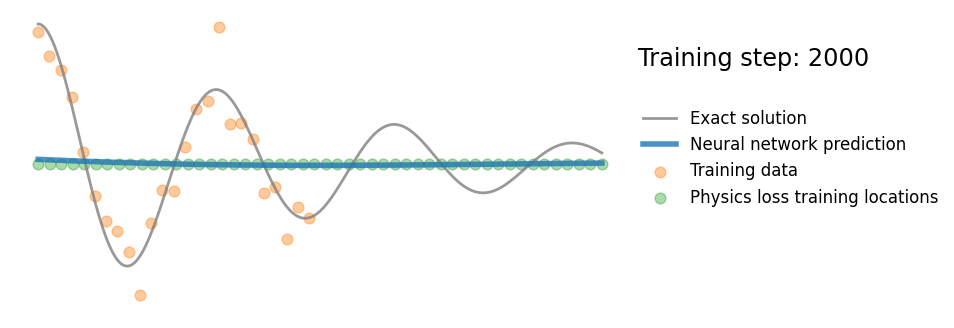

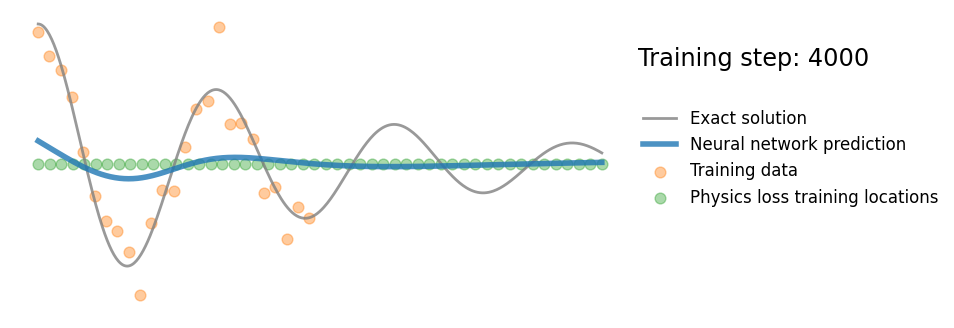

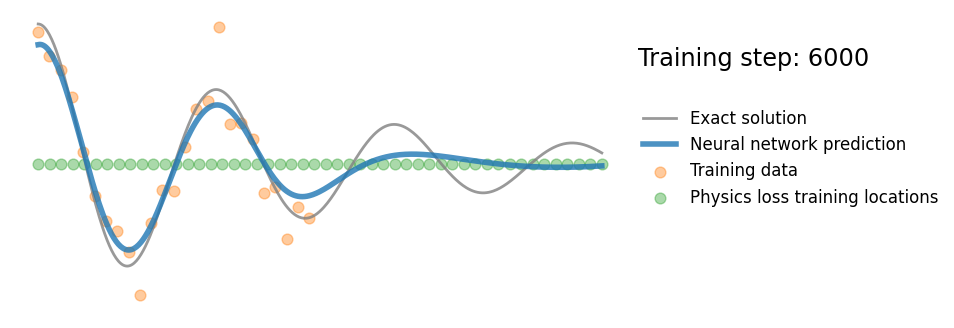

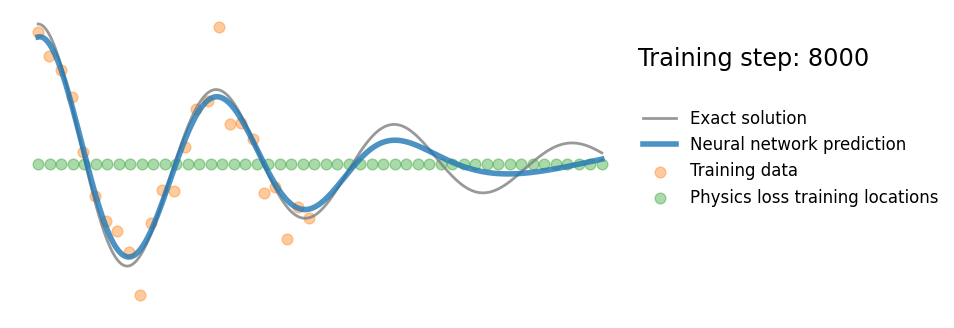

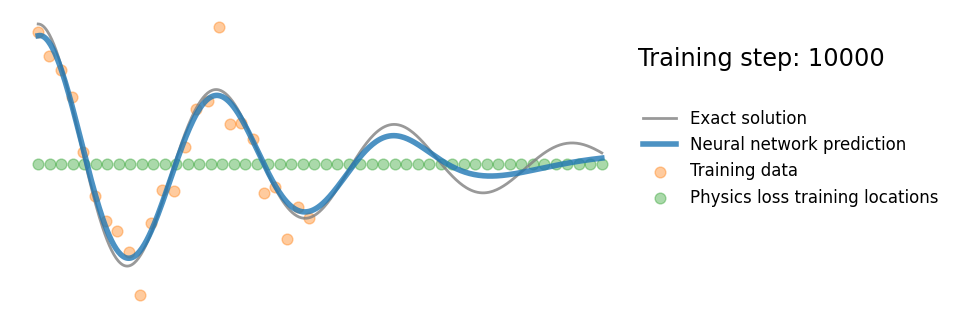

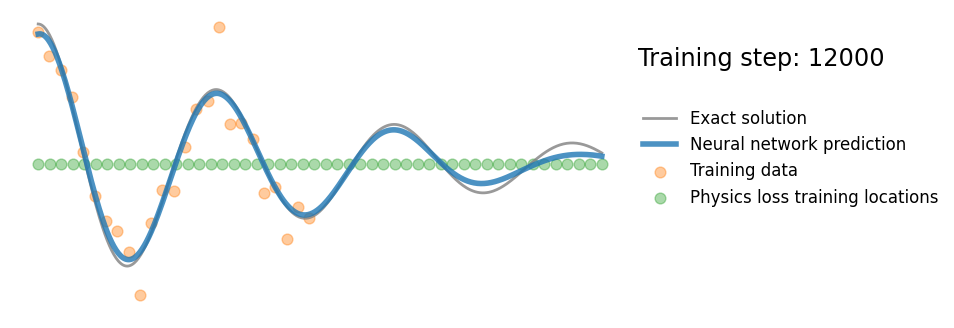

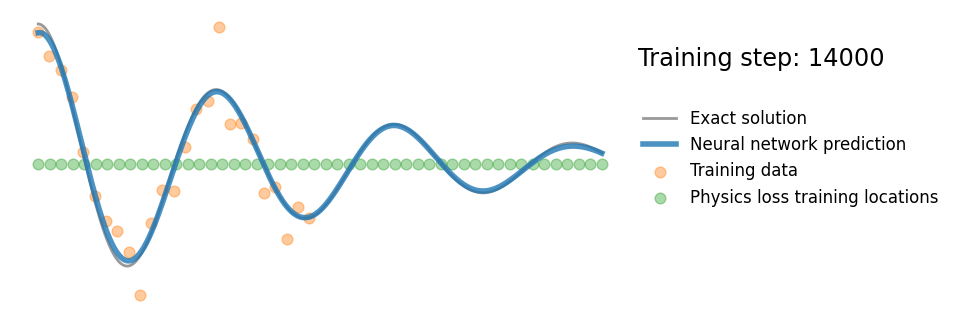

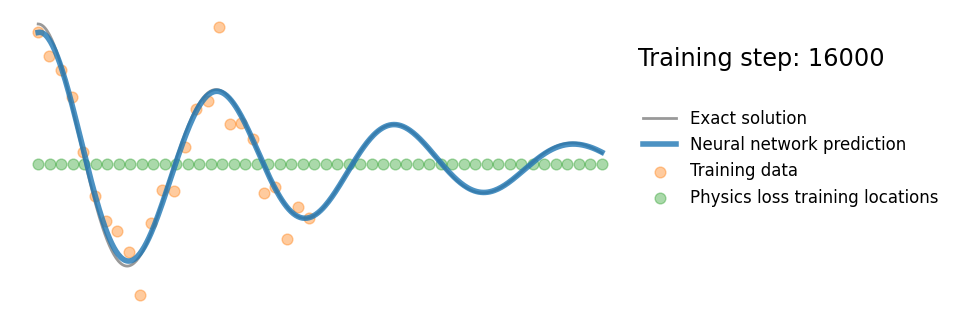

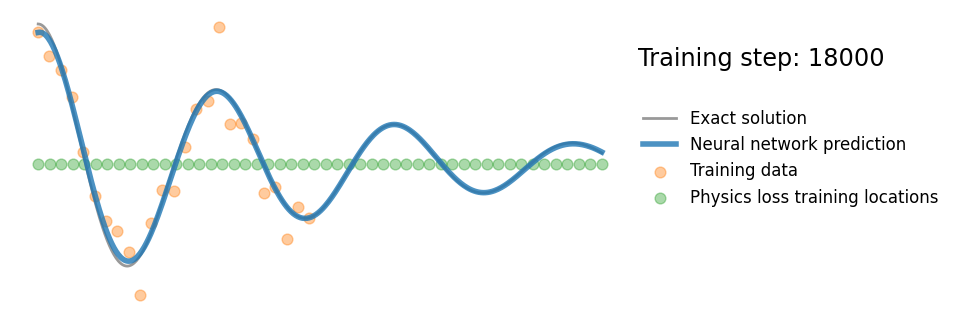

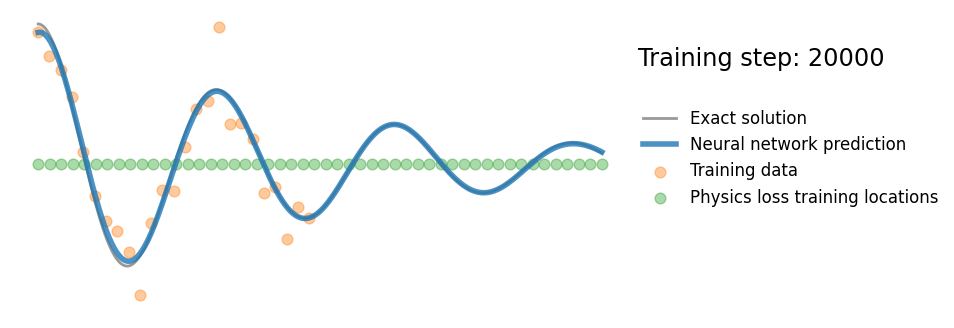

In [58]:
x_physics = torch.linspace(0,1,50).view(-1,1).requires_grad_(True) # Sample locations over the problem domain
mu, k = 2*d, w0**2

# Check if GPU is available and move tensors to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_physics = x_physics.to(device)
x_data = x_data.to(device)
y_data = y_data.to(device)

torch.manual_seed(123)
model = FCN(1,1,32,3).to(device) # Move model to GPU
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
loss_history = []
for i in range(20000):
    optimizer.zero_grad()

    # Compute the "data loss"
    yh = model(x_data)
    lossData = torch.mean((yh-y_data)**2)# use mean squared error

    # Compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp, device=device), create_graph=True)[0] # Computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx, device=device),  create_graph=True)[0] # Computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp # Computes the residual of the 1D harmonic oscillator differential equation
    lossPhys = torch.mean(physics**2)

    # Backpropagate joint loss
    loss = lossData + (1e-4)*lossPhys # Add two loss terms together
    loss.backward()
    loss_history.append(loss.item())
    optimizer.step()


    # Plot the result as training progresses
    if (i+1) % 100 == 0:

        # Move tensors to CPU for plotting
        yh_cpu = model(x.to(device)).detach().cpu()
        xp_cpu = x_physics.detach().cpu()
        x_cpu = x.detach().cpu()
        y_cpu = y.detach().cpu()
        x_data_cpu = x_data.detach().cpu()
        y_data_cpu = y_data.detach().cpu()

        plot_result(x_cpu,y_cpu,x_data_cpu,y_data_cpu,yh_cpu,xp_cpu)

        file = "plots/pinnData_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 2000 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("pinn.gif", files, fps=20, loop=0)

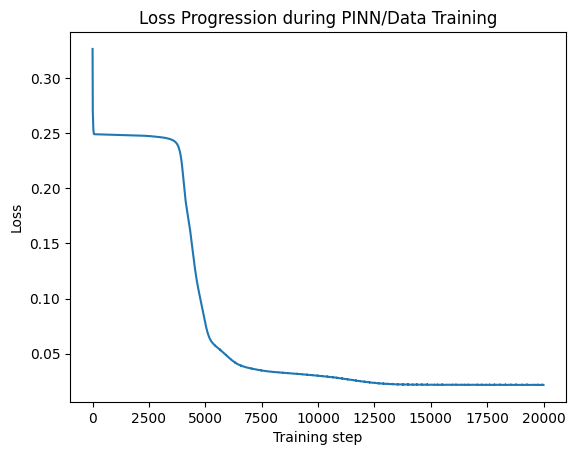

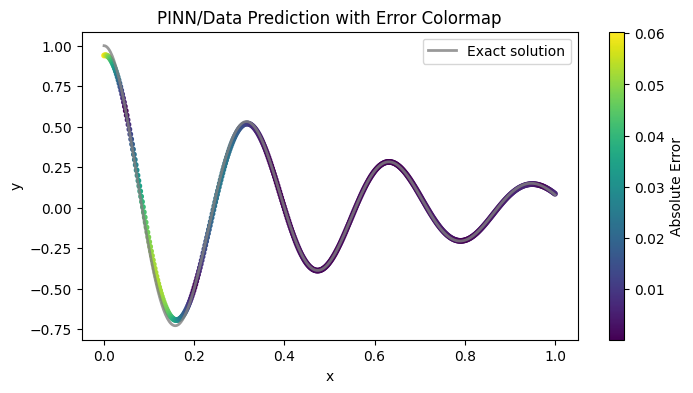

In [59]:
lossPlot(loss_history, "PINN/Data")
errorPlot(x_cpu, y_cpu, yh_cpu, "PINN/Data")

##**PINN / IC**

Las PINNs pueden aproximar las soluciones analíticas sin necesidad de datos experimentales. Para ello, además de la pérdida física, se deben incorporar nuevos términos de pérdida que tomen en cuenta las condiciones iniciales o las condiciones de frontera del sistema.

Recordemos que para este sistema:

$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$

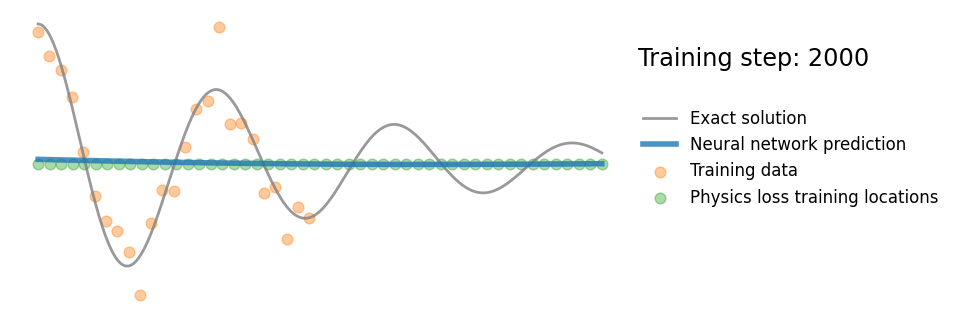

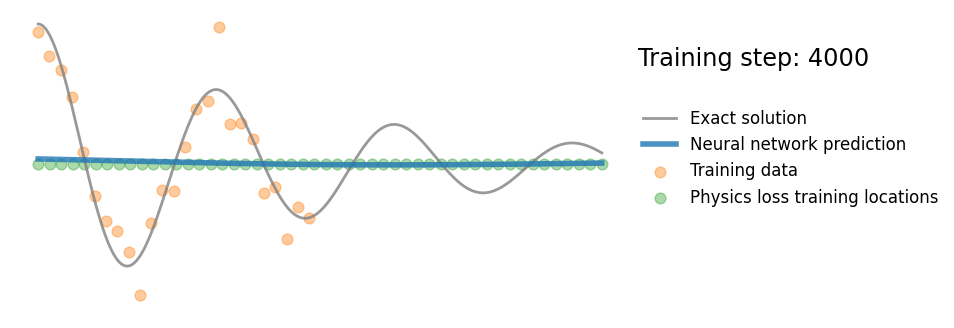

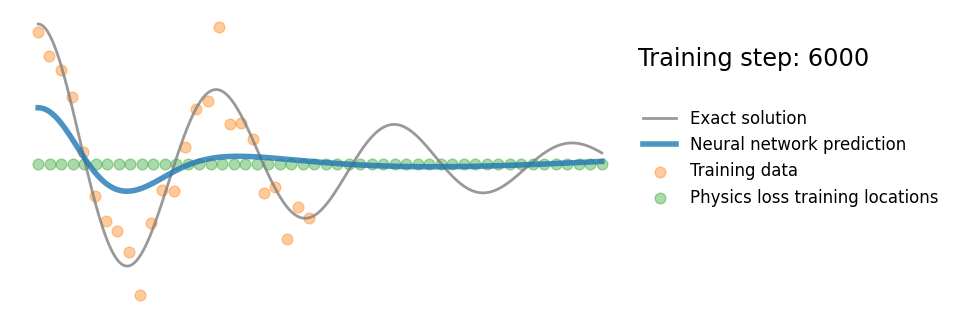

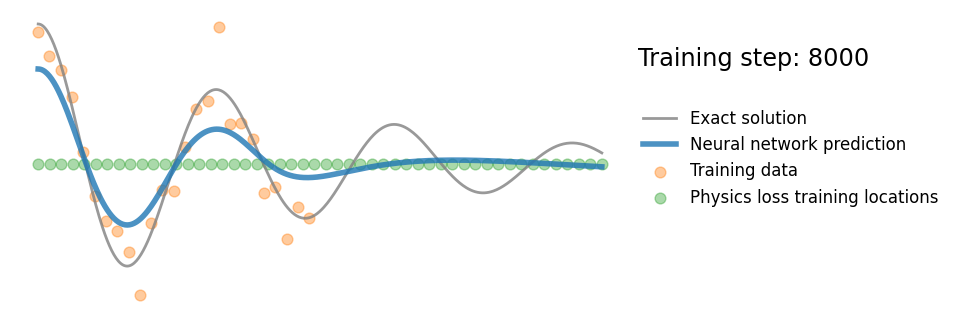

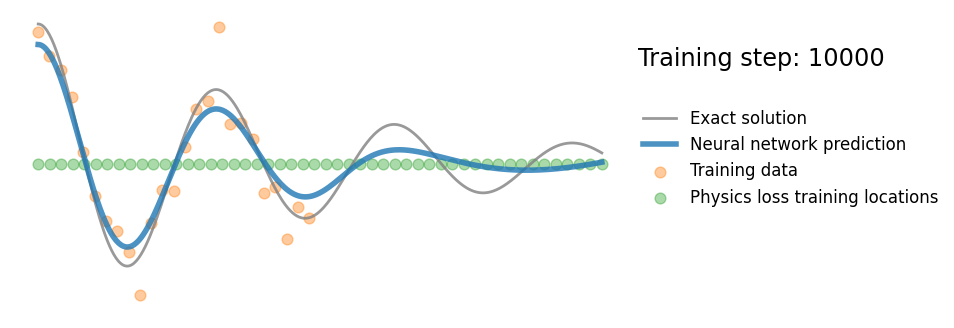

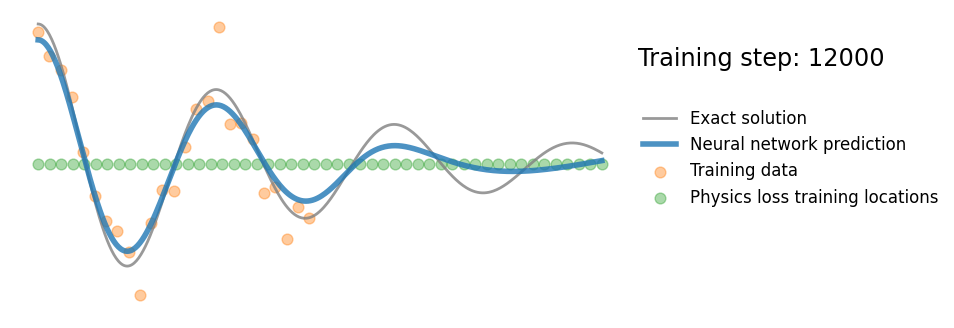

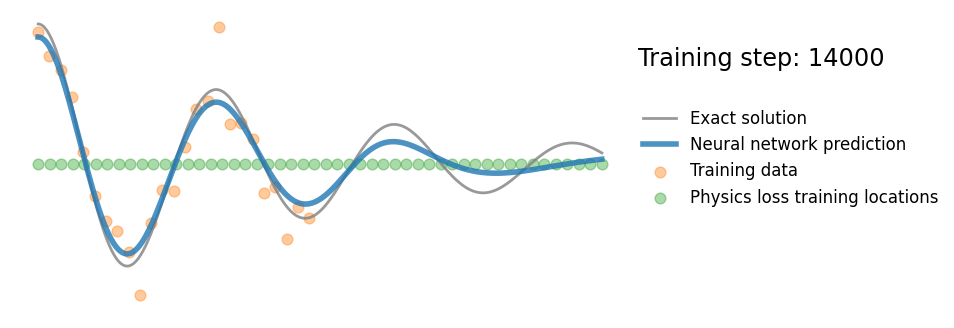

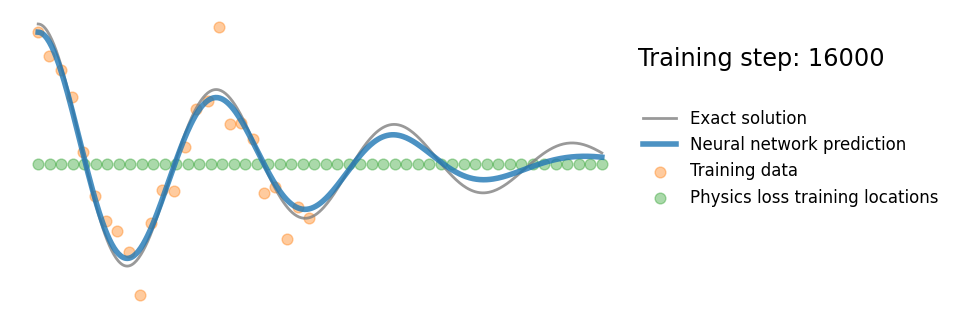

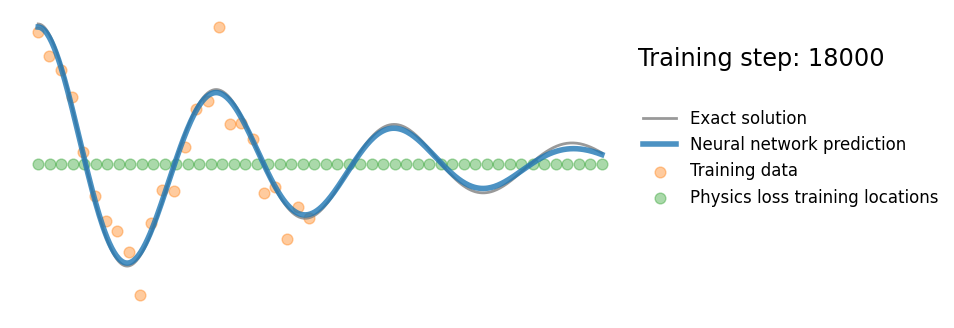

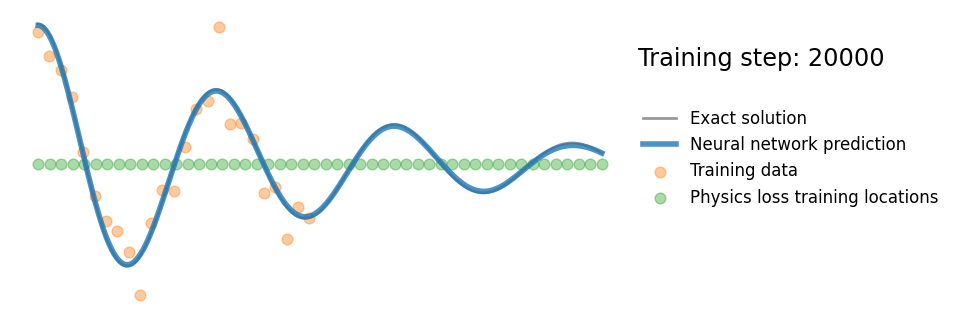

In [60]:
x_physics = torch.linspace(0,1,50).view(-1,1).requires_grad_(True) # Sample locations over the problem domain
mu, k = 2*d, w0**2

# Check if GPU is available and move tensors to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_physics = x_physics.to(device)
x_data = x_data.to(device)
y_data = y_data.to(device)

torch.manual_seed(123)
model = FCN(1,1,32,3).to(device) # Move model to GPU
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
loss_history = []
for i in range(20000):
    optimizer.zero_grad()

    # Compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp, device=device), create_graph=True)[0] # Computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx, device=device),  create_graph=True)[0] # Computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp # Computes the residual of the 1D harmonic oscillator differential equation
    lossPhys = torch.mean(physics**2)

    # Compute initial condition loss
    x_initial = torch.zeros(1, 1, device=device, requires_grad=True)
    y_initial = model(x_initial)
    dx_initial = torch.autograd.grad(y_initial, x_initial, torch.ones_like(y_initial, device=device), create_graph=True)[0]

    lossPos = torch.mean((y_initial - 1)**2) # x(0) = 1
    lossVel = torch.mean(dx_initial**2) # dx/dt(0) = 0


    # Backpropagate joint loss
    loss = lossPhys + 1000*(lossPos + lossVel) # Add physics loss and initial condition loss terms together
    loss.backward()
    loss_history.append(loss.item())
    optimizer.step()


    # Plot the result as training progresses
    if (i+1) % 100 == 0:

        # Move tensors to CPU for plotting
        yh_cpu = model(x.to(device)).detach().cpu()
        xp_cpu = x_physics.detach().cpu()
        x_cpu = x.detach().cpu()
        y_cpu = y.detach().cpu()
        x_data_cpu = x_data.detach().cpu()
        y_data_cpu = y_data.detach().cpu()

        plot_result(x_cpu,y_cpu,x_data_cpu,y_data_cpu,yh_cpu,xp_cpu)

        file = "plots/pinnIC_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 2000 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("pinn2.gif", files, fps=20, loop=0)

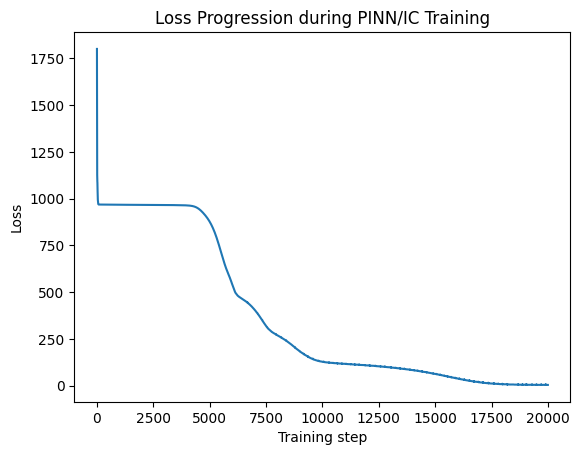

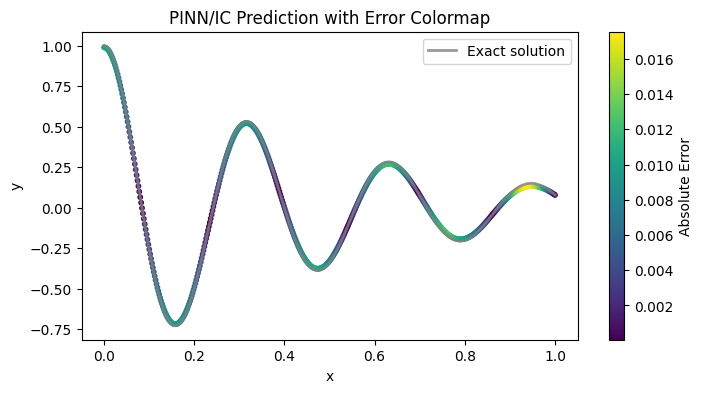

In [61]:
lossPlot(loss_history, "PINN/IC")
errorPlot(x_cpu, y_cpu, yh_cpu, "PINN/IC")

In [62]:
#!rm -rf "plots"